In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

In [2]:
SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

def init(N):
    L = np.sqrt(N)
    
    if not L.is_integer():
        raise 'N must be a square'
    
    cells = np.empty(N, dtype=int)
    cells.fill(SUSCEPTIBLE)
    cells[0] = INFECTED
    
    neighbors_list = np.empty((N, 4), dtype=int)
    for i in range(N):
        up = i + 1
        down = i - 1
        left = i - L
        right = i + L
        
        # apply periodic boundary conditions
        if i % L == 0:
            down = i + L - 1
        if (i + 1) % L == 0:
            up = i - L + 1
        if i < L:
            left = N - L + i
        if i < N and i >= N - L:
            right = i - (N - L)
            
        neighbors_list[i] = [up, right, down, left]
        
    return cells, neighbors_list


def simulate(N, prob_contamination, prob_recovery):
    cells, neighbors_list = init(N)
    state_evolution = [cells.copy()]

    susceptible_count = np.count_nonzero(cells == SUSCEPTIBLE)
    infected_count = np.count_nonzero(cells == INFECTED)
    recovered_count = np.count_nonzero(cells == RECOVERED)

    susceptible_over_time = np.array([susceptible_count])
    infected_over_time = np.array([infected_count])
    recovered_over_time = np.array([recovered_count])

    prev_infected_count = infected_count

    while infected_count != N and infected_count != 0:
        for i in range(N):
            # if cell is not infected, it can't change the system
            if (cells[i] != INFECTED):
                continue

            r = np.random.uniform()

            if (r < prob_recovery):
                cells[i] = RECOVERED
                infected_count -= 1
                recovered_count += 1

            neighbors = neighbors_list[i]

            for neighbor in neighbors:
                # only susceptible neighbors can be infected
                if (cells[neighbor] == INFECTED or cells[neighbor] == RECOVERED):
                    continue

                if (r < prob_contamination):
                    cells[neighbor] = INFECTED
                    infected_count += 1
                    susceptible_count -= 1

        susceptible_over_time = np.append(susceptible_over_time, susceptible_count)
        infected_over_time = np.append(infected_over_time, infected_count)
        recovered_over_time = np.append(recovered_over_time, recovered_count)
    
        delta_infected = np.abs(prev_infected_count - infected_count)

        # at every variation of 10 or more, take a snapshot of the system
        if (delta_infected >= 10):
            state_evolution.append(cells.copy())
            prev_infected_count = infected_count

    return susceptible_over_time, infected_over_time, recovered_over_time, state_evolution


def get_valid_value(a, b):
    if (a != None): return a

    return b


# computes one term of the average
def get_avg_term(arr_1, arr_2, n_total):
    zip_arr = it.zip_longest(arr_1, arr_2)

    # (sums two arrays dividing the second one by n_total)
    # if one arr is bigger than the other, repeats the last element of the smaller one
    return [get_valid_value(x, arr_1[-1]) + get_valid_value(y, arr_2[-1])/n_total for x, y in zip_arr]


def plot_avg_evolution(susceptible_avg, infected_avg, recovered_avg, title):
    fig, ax = plt.subplots()
    ax.plot(susceptible_avg, label="susceptible")
    ax.plot(infected_avg, label="infected")
    ax.plot(recovered_avg, label="recovered")
    ax.set_title(title)

    ax.legend()

    plt.show()


def plot_state_evolution(data, title):
    length = len(data)
    q, r = divmod(length, 3)
    nrows = q + (1 if r else 0)
    fig, axs = plt.subplots(nrows, 3, sharex=True, sharey=True)
    axs_1d = axs.flatten()
    for i, data_1d in enumerate(data):
        L = int(np.sqrt(len(data_1d)))
        data_2d = data_1d.reshape(L, L)

        cell_codes = [SUSCEPTIBLE, INFECTED, RECOVERED]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', colors)
        norm = matplotlib.colors.Normalize(vmin=np.min(cell_codes), vmax=np.max(cell_codes))
        im = axs_1d[i].imshow(data_2d, cmap=cmap, norm=norm)

    fig.suptitle(title)
    plt.show()

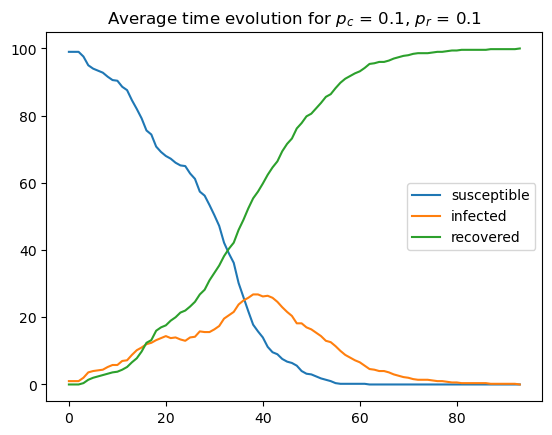

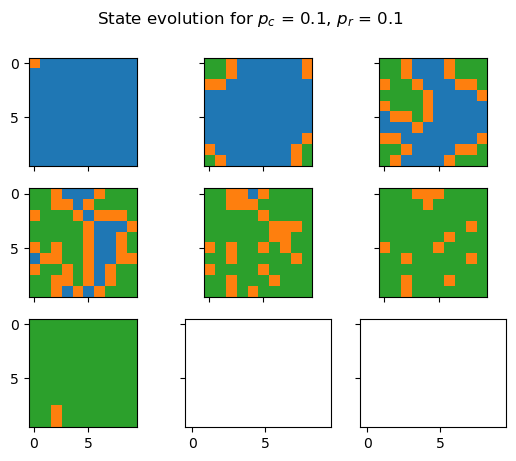

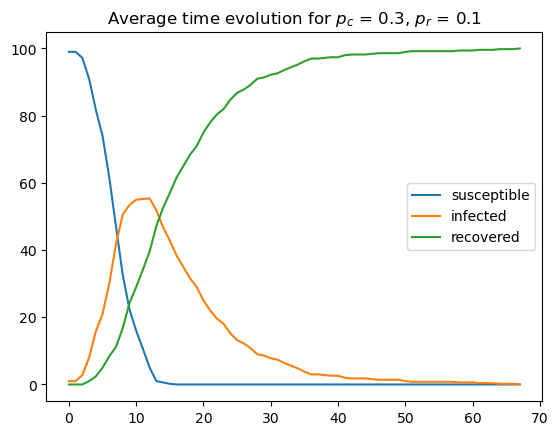

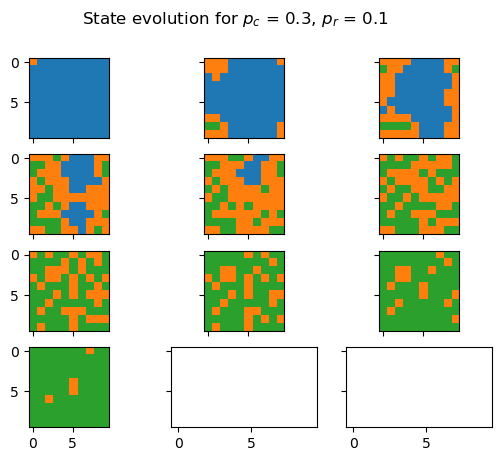

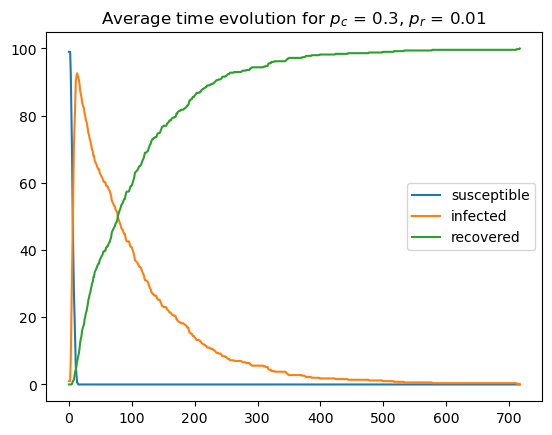

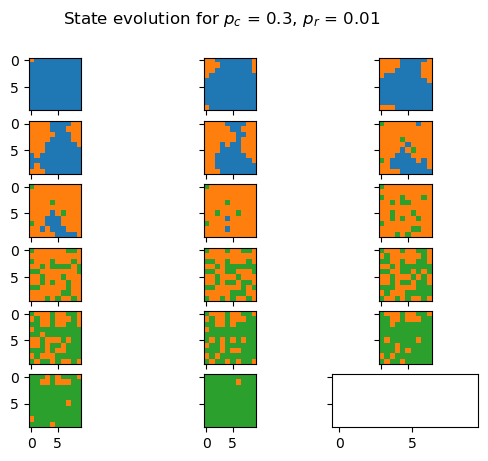

In [3]:
N = 100

probs_contamination = [0.1, 0.3, 0.3]
probs_recovery = [0.1, 0.1, 0.01]

n_simulations = 5

for i, _ in enumerate(probs_contamination):
    susceptible_avg = [0]
    infected_avg = [0]
    recovered_avg = [0]

    for j in range(n_simulations):
        susceptible_over_time, infected_over_time, recovered_over_time, state_evolution = simulate(N, probs_contamination[i], probs_recovery[i])

        susceptible_avg = get_avg_term(susceptible_avg, susceptible_over_time, n_simulations)
        infected_avg = get_avg_term(infected_avg, infected_over_time, n_simulations)
        recovered_avg = get_avg_term(recovered_avg, recovered_over_time, n_simulations)

    pc = probs_contamination[i]
    pr = probs_recovery[i]
    title = f"Average time evolution for $p_c$ = {pc}, $p_r$ = {pr}"
    plot_avg_evolution(susceptible_avg, infected_avg, recovered_avg, title)

    plot_state_evolution(state_evolution, f"State evolution for $p_c$ = {pc}, $p_r$ = {pr}")